# LeNet

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

At a high level, LeNet (LeNet-5) consists of two parts: 
* a convolutional encoder consisting of two convolutional layers; and 
* a dense block consisting of three fully connected layers

The basic units in each convolutional block are a convolutional layer, a sigmoid activation function, and a subsequent average pooling operation. 

In [3]:
def init_cnn(module):
    """Initialize the weights of the convolutional neural network"""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    """The LeNet architecture."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.Sigmoid(),
            nn.LazyLinear(84),
            nn.Sigmoid(),
            nn.LazyLinear(num_classes),
        )

We have taken some liberty in the reproduction of LeNet insofar as we have replaced the Gaussian activation layer by a softmax layer. This greatly simplifies the implementation, not least due to the fact that the Gaussian decoder is rarely used nowadays. Other than that, this network matches the original LeNet-5 architecture.

In [7]:
@d2l.add_to_class(LeNet)
def layer_summary(self, X_shape):
    X = torch.rand(X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


## Training

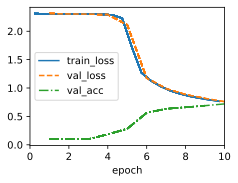

In [8]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

In [9]:
def show_wrongpreds(data):
    X, y = next(iter(data.val_dataloader()))
    preds = model(X).argmax(1)
    preds[:10], y[:10]
    accuracy = (preds == y).float().mean()
    print(f'accuracy: {accuracy:.2f}')
    wrong = preds.type(y.dtype) != y
    X, y, preds = X[wrong], y[wrong], preds[wrong]
    labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
    data.visualize([X, y], labels=labels)

accuracy: 0.76


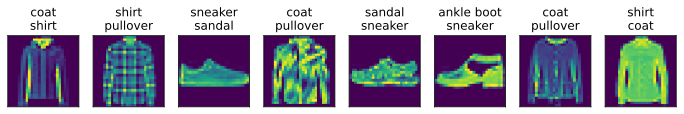

In [10]:
wrongpreds = show_wrongpreds(data)